#### Model v2 -- to run code below I had to switch into a different virtual environment and install just these packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
from skimage.filters import gabor_kernel
import copy
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import copy
import datetime
import modeling

## do 16 16 
### do percent change in accuracy instead of accuracy differences 

In [2]:
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

## Load CIFAR-10 dataset (training = 50,000 images, test = 10,000 images)

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_trainset, cifar_valset = random_split(cifar_trainset, [int(len(cifar_trainset) * 0.9), int(len(cifar_trainset) * 0.1)])
cifar_train_loader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)    # shape = (40000, 1, 32, 32)
cifar_val_loader = DataLoader(cifar_valset, batch_size=batch_size, shuffle=False)
cifar_test_loader = DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

gabor_trainset = modeling.GaborDataset(num_images=45000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_valset = modeling.GaborDataset(num_images=5000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_testset = modeling.GaborDataset(num_images=10000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_train_loader = DataLoader(gabor_trainset, batch_size=batch_size, shuffle=True)
gabor_val_loader = DataLoader(gabor_valset, batch_size=batch_size, shuffle=False)
gabor_test_loader = DataLoader(gabor_testset, batch_size=batch_size, shuffle=False)

assert len(cifar_trainset) + len(cifar_valset) == 50000
assert len(gabor_trainset) == len(cifar_trainset)
assert len(gabor_valset) == len(cifar_valset)
assert len(gabor_testset) == len(cifar_testset)

combined_trainset = ConcatDataset([cifar_trainset, gabor_trainset])
combined_loader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
combined_valset = ConcatDataset([cifar_valset, gabor_valset])
combined_val_loader = DataLoader(combined_valset, batch_size=batch_size, shuffle=True) # need to shuffle val set too because of concatdataset

Files already downloaded and verified
Files already downloaded and verified


In [2]:
gabor_valset = modeling.GaborDatasetNoisy(noise_level=0.05, orientation_jitter=0.05)

In [3]:
gabor_valset[0]

AttributeError: 'numpy.random._generator.Generator' object has no attribute 'randint'

In [ ]:
np.random.seed(42).

11


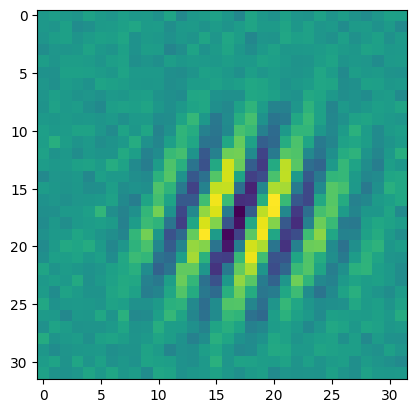

In [54]:
data = gabor_valset[1]

## add offset to the image (i.e. move it up/down/left/right by a few pixels)
offset = np.random.randint(-3, 3)
image = np.roll(data[0][0], shift=(offset, offset), axis=(0, 1))

plt.imshow(image)
print(data[1])


In [51]:
offset

1.469079813843397

In [45]:
np.roll?


Signature:       np.roll(a, shift, axis=None)
Call signature:  np.roll(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function roll at 0x7fae7d5eb400>
File:            ~/anaconda3/envs/neural_net_basics/lib/python3.10/site-packages/numpy/core/numeric.py
Docstring:      
Roll array elements along a given axis.

Elements that roll beyond the last position are re-introduced at
the first.

Parameters
----------
a : array_like
    Input array.
shift : int or tuple of ints
    The number of places by which elements are shifted.  If a tuple,
    then `axis` must be a tuple of the same size, and each of the
    given axes is shifted by the corresponding number.  If an int
    while `axis` is a tuple of ints, then the same value is used for
    all given axes.
axis : int or tuple of ints, optional
    Axis or axes along which elements are shifted.  By default, the
    array is flattened before shifting, after which the original
    shape is restored.

Returns
-----

In [3]:
model = modeling.ConvNet(in_channels=1, height=32, width=32)
model, train_losses, val_losses, gabor_vals, cifar_vals = modeling.train_model(
    model, 
    train_loader=combined_loader,
    batch_size=64,
    probe_size=64,
    val_dataset=combined_valset,
    num_epochs=35,
    )

Training model with tag: 2025_10_16_19:20:06


Epochs:   0%|          | 0/35 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

KeyboardInterrupt: 

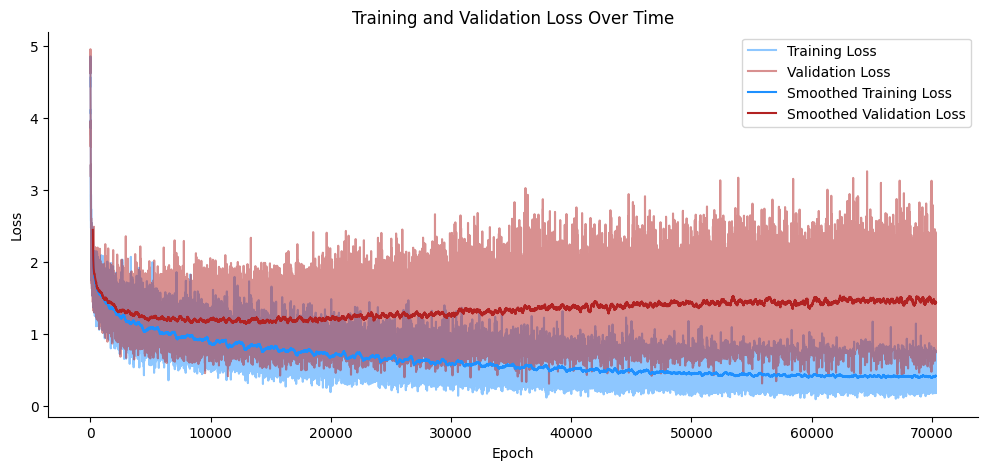

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_losses, label="Training Loss", color='dodgerblue', alpha=0.5)
axs.plot(val_losses, label="Validation Loss", color='firebrick', alpha=0.5)

# plot smoothed losses
window_size = 200
train_losses_smooth = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
val_losses_smooth = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
axs.plot(range(window_size - 1, len(train_losses)), train_losses_smooth, label="Smoothed Training Loss", color='dodgerblue')
axs.plot(range(window_size - 1, len(val_losses)), val_losses_smooth, label="Smoothed Validation Loss", color='firebrick')
axs.set_xlabel("Epoch")
axs.set_ylabel("Loss")
axs.set_title("Training and Validation Loss Over Time")
axs.legend()
# axs.set_xlim(0, 10000)
plt.gca().spines[['top', 'right']].set_visible(False)


Text(0.5, 1.0, 'Validation Accuracy over Epochs')

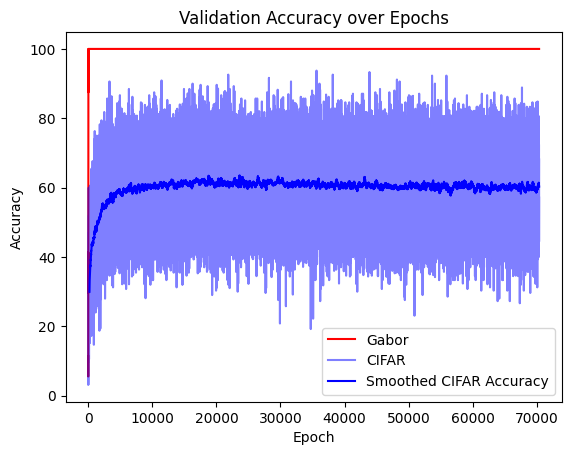

In [17]:
plt.plot(gabor_vals, label='Gabor', color='red', alpha=1)
plt.plot(cifar_vals, label='CIFAR', color='blue', alpha=0.5)

# plot smoothed accuracies
window_size = 200
cifar_vals_smooth = np.convolve(cifar_vals, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(cifar_vals)), cifar_vals_smooth, label="Smoothed CIFAR Accuracy", color='blue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.xlim(-10, 200)
plt.title('Validation Accuracy over Epochs')

In [7]:
noise_results = {
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for noise in noise_levels:
    noisy_model = copy.deepcopy(model)

    noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
    noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noisy_model = copy.deepcopy(model)
    noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
    noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noise_results['noise_level'].append(noise)
    noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
    noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
    noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
    noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)


In [8]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0.00,100.00,56.58,100.00,56.58
1,0.05,100.00,50.16,100.00,50.31
2,0.10,100.00,27.00,100.00,54.55
3,0.15,100.00,31.07,100.00,46.05
4,0.20,99.99,26.81,100.00,31.32
5,0.25,100.00,31.07,100.00,37.44
6,0.30,99.97,13.76,100.00,33.27
7,0.35,100.00,32.41,100.00,34.60
8,0.40,97.08,22.69,100.00,20.41
9,0.45,98.49,20.44,100.00,18.27


In [9]:
noise_results_df['noisy1_gabor_pctchange'] = (noise_results_df['noisy1_gabor_acc'].iloc[0] - noise_results_df['noisy1_gabor_acc']) / noise_results_df['noisy1_gabor_acc'].iloc[0] * 100
noise_results_df['noisy2_gabor_pctchange'] = (noise_results_df['noisy2_gabor_acc'].iloc[0] - noise_results_df['noisy2_gabor_acc']) / noise_results_df['noisy2_gabor_acc'].iloc[0] * 100
noise_results_df['noisy1_cifar_pctchange'] = (noise_results_df['noisy1_cifar_acc'].iloc[0] - noise_results_df['noisy1_cifar_acc']) / noise_results_df['noisy1_cifar_acc'].iloc[0] * 100
noise_results_df['noisy2_cifar_pctchange'] = (noise_results_df['noisy2_cifar_acc'].iloc[0] - noise_results_df['noisy2_cifar_acc']) / noise_results_df['noisy2_cifar_acc'].iloc[0] * 100

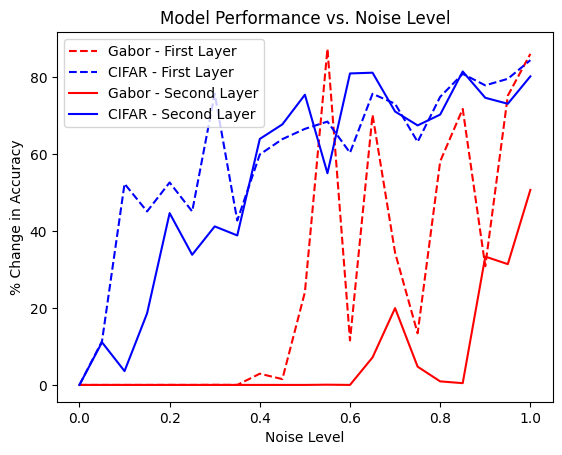

In [10]:
import seaborn as sns
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_gabor_pctchange', label='Gabor - First Layer', color='red', linestyle='--')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_cifar_pctchange', label='CIFAR - First Layer', color='blue', linestyle='--')

sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_gabor_pctchange', label='Gabor - Second Layer', color='red')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_cifar_pctchange', label='CIFAR - Second Layer', color='blue')

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
plt.legend()

In [12]:
#### stability plots ####
results = {
    'idx': [],
    'gabor_acc': [],
    'cifar_acc': [],
}

noise_results = {
    'idx': [],
    'noise_level': [],
    'noisy1_gabor_acc': [],
    'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for i in range(20):
    model = modeling.ConvNet(in_channels=1, height=32, width=32)
    model, losses, val_losses, _, _ = modeling.train_model(model, combined_loader, val_dataset=combined_valset, num_epochs=10)
    
    gabor_acc = modeling.evaluate_gabor_accuracy(model, gabor_test_loader)
    cifar_acc = modeling.evaluate_cifar_accuracy(model, cifar_test_loader)

    results['idx'].append(i)
    results['gabor_acc'].append(gabor_acc)
    results['cifar_acc'].append(cifar_acc)

    for noise in noise_levels:
        noisy_model = copy.deepcopy(model)

        noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
        noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noisy_model = copy.deepcopy(model)
        noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
        noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noise_results['idx'].append(i)
        noise_results['noise_level'].append(noise)
        noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
        noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
        noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
        noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)
    
    print(f'Iteration {i+1}/10 complete.')

Training model with tag: 2025_10_16_17:20:05


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 1/10 complete.
Training model with tag: 2025_10_16_17:21:48


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 2/10 complete.
Training model with tag: 2025_10_16_17:22:49


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 3/10 complete.
Training model with tag: 2025_10_16_17:23:53


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 4/10 complete.
Training model with tag: 2025_10_16_17:25:15


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 5/10 complete.
Training model with tag: 2025_10_16_17:26:37


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 6/10 complete.
Training model with tag: 2025_10_16_17:27:59


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 7/10 complete.
Training model with tag: 2025_10_16_17:29:09


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 8/10 complete.
Training model with tag: 2025_10_16_17:30:51


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 9/10 complete.
Training model with tag: 2025_10_16_17:32:38


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 10/10 complete.
Training model with tag: 2025_10_16_17:34:01


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 11/10 complete.
Training model with tag: 2025_10_16_17:35:29


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 12/10 complete.
Training model with tag: 2025_10_16_17:36:34


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 13/10 complete.
Training model with tag: 2025_10_16_17:38:00


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 14/10 complete.
Training model with tag: 2025_10_16_17:39:26


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 15/10 complete.
Training model with tag: 2025_10_16_17:40:47


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 16/10 complete.
Training model with tag: 2025_10_16_17:42:41


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 17/10 complete.
Training model with tag: 2025_10_16_17:44:08


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 18/10 complete.
Training model with tag: 2025_10_16_17:45:15


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 19/10 complete.
Training model with tag: 2025_10_16_17:46:39


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Early stopping triggered.
Iteration 20/10 complete.


In [13]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,idx,noise_level,noisy1_gabor_acc,noisy1_cifar_acc,noisy2_gabor_acc,noisy2_cifar_acc
0,0,0.00,100.00,61.75,100.00,61.75
1,0,0.05,100.00,56.49,100.00,60.19
2,0,0.10,100.00,37.00,100.00,58.83
3,0,0.15,100.00,26.45,100.00,42.11
4,0,0.20,100.00,12.64,100.00,51.08
...,...,...,...,...,...,...
415,19,0.80,61.74,9.66,70.01,14.01
416,19,0.85,29.59,16.89,69.02,15.82
417,19,0.90,54.82,17.46,80.08,10.76
418,19,0.95,67.77,15.32,73.18,15.84


(0.0, 104.3999087872236)

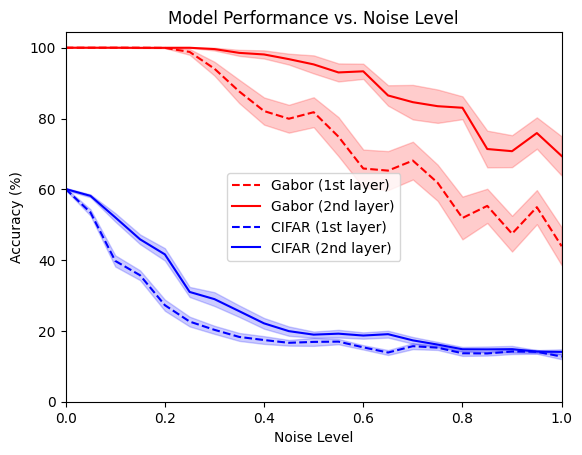

In [14]:
import seaborn as sns

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy1_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (1st layer)'
    )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
plt.xlim(0, 1)
plt.ylim(bottom=0)

In [15]:
pct_change_dfs = []

for i in range(10):
    temp_df = noise_results_df[noise_results_df['idx'] == i]
    temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'].iloc[0] - temp_df['noisy1_gabor_acc']) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
    temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'].iloc[0] - temp_df['noisy2_gabor_acc']) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
    temp_df['noisy1_cifar_pctchange'] = (temp_df['noisy1_cifar_acc'].iloc[0] - temp_df['noisy1_cifar_acc']) / temp_df['noisy1_cifar_acc'].iloc[0] * 100
    temp_df['noisy2_cifar_pctchange'] = (temp_df['noisy2_cifar_acc'].iloc[0] - temp_df['noisy2_cifar_acc']) / temp_df['noisy2_cifar_acc'].iloc[0] * 100

    pct_change_dfs.append(temp_df)

pct_change_df = pd.concat(pct_change_dfs)

/tmp/ipykernel_1528344/2653124574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'].iloc[0] - temp_df['noisy1_gabor_acc']) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_1528344/2653124574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'].iloc[0] - temp_df['noisy2_gabor_acc']) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_1528344/2653124574.py:7: Sett

(-10.0, 84.79844112471943)

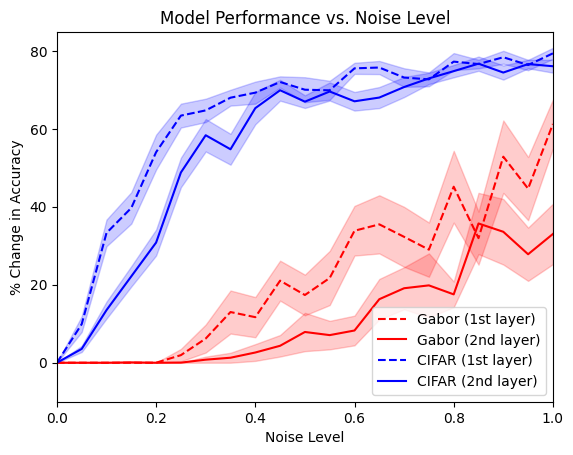

In [16]:
import seaborn as sns

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    linestyle='--',
    color='red',
    label='Gabor (1st layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy1_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    linestyle='--',
    label='CIFAR (1st layer)'
    )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
plt.xlim(0, 1)
plt.ylim(bottom=-10)